<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.7.0


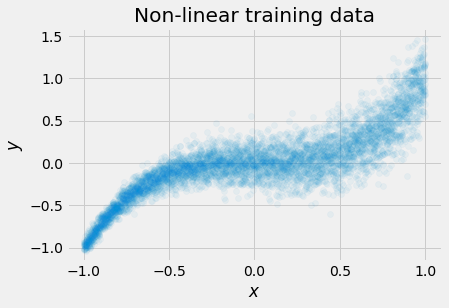

In [10]:
plt.style.use('fivethirtyeight')
tfd = tfp.distributions
tfpl = tfp.layers

# Create non-linear data
n_samples = int(5e3)
x_train = np.linspace(-1, 1, n_samples)[:, np.newaxis]
y_train = x_train**3 + 0.1*(1.5 + x_train)*np.random.randn(n_samples)[:, np.newaxis]

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.05)
plt.title('Non-linear training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [11]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Note: Our prior is a non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model

In [13]:
# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

In [14]:
# Define the model
def get_full_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=8,
                              input_shape=(1,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

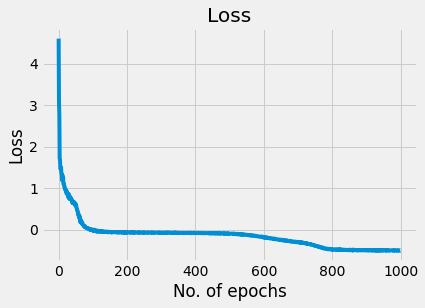

In [15]:
# Get the model
model_full = get_full_model(n_samples)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=0)

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

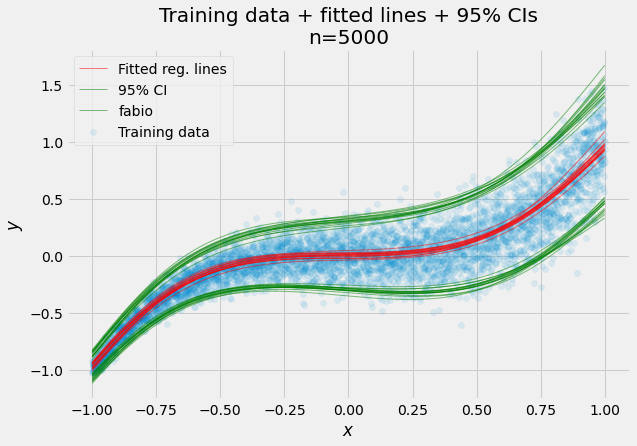

In [17]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1, label="fabio")
    else:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()